# Baysor evaluation

In [1]:
import pandas as pd
import os
import numpy as np
from tqdm.notebook import tqdm
import scanpy as sc
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.cluster import adjusted_mutual_info_score

/home/max/Desktop/docker-scanpy/.venv/lib64/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/max/Desktop/docker-scanpy/.venv/lib64/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/max/Desktop/docker-scanpy/.venv/lib64/python3.11/site-

In [2]:
# Add path to the Baysor ouput
output_path = 'data'

In [3]:
# Read in Baysor output and cellpose output trasncripts files
transcripts = pd.read_csv(os.path.join(output_path, 'transcripts.csv'))
transcripts_cellpose = pd.read_csv(os.path.join(output_path, 'transcripts_cellpose.csv'))

In [4]:
# Preprocess and format the csvs
transcripts_cellpose.index = transcripts_cellpose.transcript_id.values
transcripts.index = transcripts.transcript_id.values
cell_values = transcripts.cell
cell_values.fillna('Not_assigned-0', inplace=True)
transcripts['cell_number'] = cell_values

Every Baysor cell contains transcripts from 1+ nuclei. If not, they are removed from accuracy calculations, as there is no way to evaluate their accuracy. I next assign the nuclei cell label that is most prevalent in each Baysor cell.

In [5]:
overlap = transcripts[transcripts.overlaps_nucleus == 1]
nuclei_associated = transcripts_cellpose.loc[overlap.transcript_id.values]
overlap['associated_nucleus'] = nuclei_associated.cell_id.values 

/tmp/ipykernel_3231/3747767411.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overlap['associated_nucleus'] = nuclei_associated.cell_id.values


In [7]:
cell_numbers = overlap.cell_number.values
associated_nuclei = overlap.associated_nucleus.values

# Create a dictionary to store the most common value for each unique cell number
most_common_values = {}

# Iterate through the pairs of cell numbers and associated nuclei
for cell_number, nucleus in zip(cell_numbers, associated_nuclei):
    if cell_number not in most_common_values:
        most_common_values[cell_number] = Counter()

    most_common_values[cell_number][nucleus] += 1

# Calculate the most common nucleus for each unique cell number
result = {cell_number: counter.most_common(1)[0][0] for cell_number, counter in most_common_values.items()}

In [8]:
keys = list(result.keys())
values = list(result.values())
transcripts = transcripts[transcripts.cell_number.isin(keys)]
max_nucleus = [result.get(i) for i in overlap.cell_number]
overlap['max_nucleus'] = max_nucleus

Let's now define leiden clusters for each segmented nucleus that is present in Baysor

In [9]:
overlap = transcripts[transcripts.overlaps_nucleus == 1]
df = pd.DataFrame(zip(overlap.cell_number.values, overlap.gene.values))
df.columns = ['cell_number', 'gene']

In [10]:
#Creating nucleus cell by gene matrix
result_nuclei = df.groupby(['cell_number', 'gene']).size().unstack(fill_value=0)
ad = sc.AnnData(X=result_nuclei.values.T, var= pd.DataFrame(index=result_nuclei.index.values), obs= pd.DataFrame(index=result_nuclei.columns)).T
ad = ad[~ad.obs.index.str.contains('Not_assigned'), :]

In [12]:
#Leiden on ad. I am filtering on 20 min nucleus counts, which has been standard in our preprocessing pipelines
sc.pp.filter_cells(ad, min_counts=20)
sc.tl.pca(ad)
sc.pp.neighbors(ad)
sc.tl.umap(ad)
sc.tl.leiden(ad)

/home/max/Desktop/docker-scanpy/.venv/lib64/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Now we can match up the leiden cluster labels to each baysor cell as training data. We want to determine how well we can predict leiden cluster from cytoplasmic reads.

In [13]:
transcripts = transcripts[transcripts['cell_number'].isin(ad.obs.index.values)]
training_annotation = ad.obs.loc[transcripts.cell_number.values]['leiden']
transcripts['training_annotation'] = training_annotation.values

Let's create a cytoplasmic cell-by-gene matrix and store the ground truth annotations for each of the cells

In [14]:
transcripts_cyto = transcripts[transcripts['overlaps_nucleus'] != 1]
df = pd.DataFrame(zip(transcripts_cyto.cell_number.values, transcripts_cyto.gene.values))
df.columns = ['cell_number', 'gene']
result = df.groupby(['cell_number', 'gene']).size().unstack(fill_value=0)

In [15]:
# Format the training labels (leiden clusters) for each baysor cell in "result"
prepare_training_labels = transcripts_cyto[['cell_number', 'training_annotation', 'x', 'y']]
prepare_training_labels.drop_duplicates(subset='cell_number', inplace=True)
prepare_training_labels.index = prepare_training_labels.cell_number.values
training_labels_sorted = prepare_training_labels.loc[result.index.values]
training_labels = training_labels_sorted.training_annotation.values

/tmp/ipykernel_3231/2906946784.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prepare_training_labels.drop_duplicates(subset='cell_number', inplace=True)


In [16]:
#Run PCA to reduce the dimensionality of the cytoplasmic reads
pca = PCA(n_components=20)
training_data = pca.fit_transform(result.values)

Now we can train up a random forest to predict label from cytoplasmic reads

In [17]:
class_weights = compute_class_weight('balanced', y=training_labels, classes=np.unique(training_labels))
# Create a dictionary of class weights
class_weight_dict = {class_label: weight for class_label, weight in zip(np.unique(training_labels), class_weights)}

In [18]:
X_train, X_test, y_train, y_test = train_test_split(training_data, training_labels, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Results

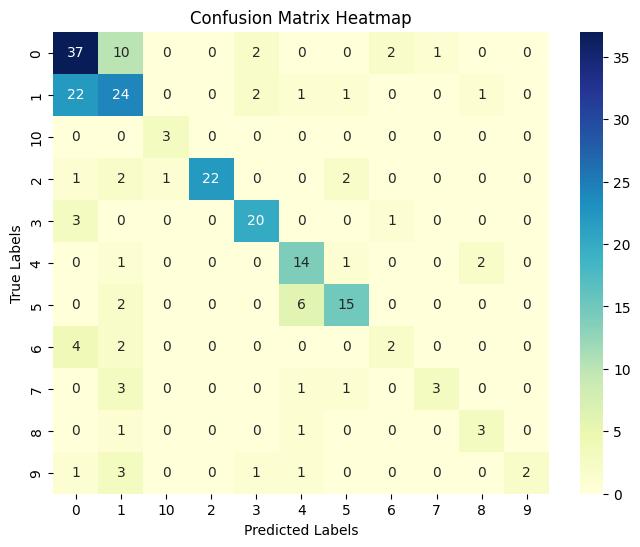

In [19]:
y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
df_conf_matrix = pd.DataFrame(conf_matrix, index=np.unique(y_test), columns=np.unique(y_test))
plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


And if we want a single score indicating how cleanly Baysor is separating all of our individual clusters:

In [20]:
ami_score = adjusted_mutual_info_score(y_test, y_pred)

In [21]:
print(ami_score)

0.47376252356755727


Closest to 1 is best